In [1]:
%load_ext autoreload
%autoreload 2

In [35]:
import torch
import ssn_dataset
from torchvision import transforms, utils
import numpy as np

csv_file = "/home/ysheng/Dataset/new_dataset/meta_data.csv"
# csv_file = "~/Dataset/soft_shadow/train/metadata.csv"
# compose_transform = None
training_dataset = ssn_dataset.SSN_Dataset(csv_file, is_training = True)
testing_dataset = ssn_dataset.SSN_Dataset(csv_file, is_training = False)

print('training set size: ', len(training_dataset))
print('testing set size: ',len(testing_dataset))

print(len(training_dataset.meta_data))
print(training_dataset.meta_data[0])

# for j in range(10):
#     for i in range(len(training_dataset)):
#         data = training_dataset[i]
# #         print("{} \r".format(i), flush=True, end="")
#         print("{} ".format(i))
    
# for i,data in enumerate(testing_dataset):
#     print("{} \r".format(i), flush=True, end="")

Dataset initialize spent: 0.8312602043151855 ms
training: 713, validation: 71
Dataset initialize spent: 0.09869170188903809 ms
training: 713, validation: 71
training set size:  713
testing set size:  71
792
['/home/ysheng/Dataset/new_dataset/base/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Standing_C/pitch_25_rot_180_shadow.npy'
 '/home/ysheng/Dataset/new_dataset/cache/mask/simulated_combine_male_short_outfits_genesis8_armani_retrosweater_Base_Pose_Standing_C/pitch_25_rot_180_mask.npy']


In [37]:
for i in range(len(training_dataset)):
    mask_img, light_img, shadow_img = training_dataset[i]
    print('mask max: ', torch.max(mask_img))
    print('light max: ', torch.max(light_img))
    print('shadow max: ', torch.max(shadow_img))
    
    break

mask max:  tensor(1.)
light max:  tensor(1.2184)
shadow max:  tensor(46.8157)


In [38]:
import sys
sys.path.append("..")
from utils.net_utils import show_batch, show_light_batch
import numpy as np
# from scipy.ndimage.filttraining_datasetort gaussian_filter
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import random

dataloader = DataLoader(training_dataset, batch_size=1, shuffle=False, num_workers=48)
valid_dataloader = DataLoader(testing_dataset, batch_size=1, shuffle=False, num_workers=4)

In [39]:
from tqdm import tqdm

total = 10
begin = time.time()
with tqdm(total=total) as t:
    for i, (mask, light, shadow,) in enumerate(dataloader):
        I_s, L_t, I_t = mask, light, shadow
        t.update()
        
        if i >= total:
            break
        
elapsed = time.time() - begin

print('{} batch spent: {}s'.format(total, elapsed))

11it [00:07,  1.57it/s]                       

10 batch spent: 7.1308019161224365s


mask min: 0.0, max: 1.0
light min: 0.0011176932603120804, max: 1.3226245641708374
shadow min: 0.0, max: 30.826004028320312
try save  img_src.png


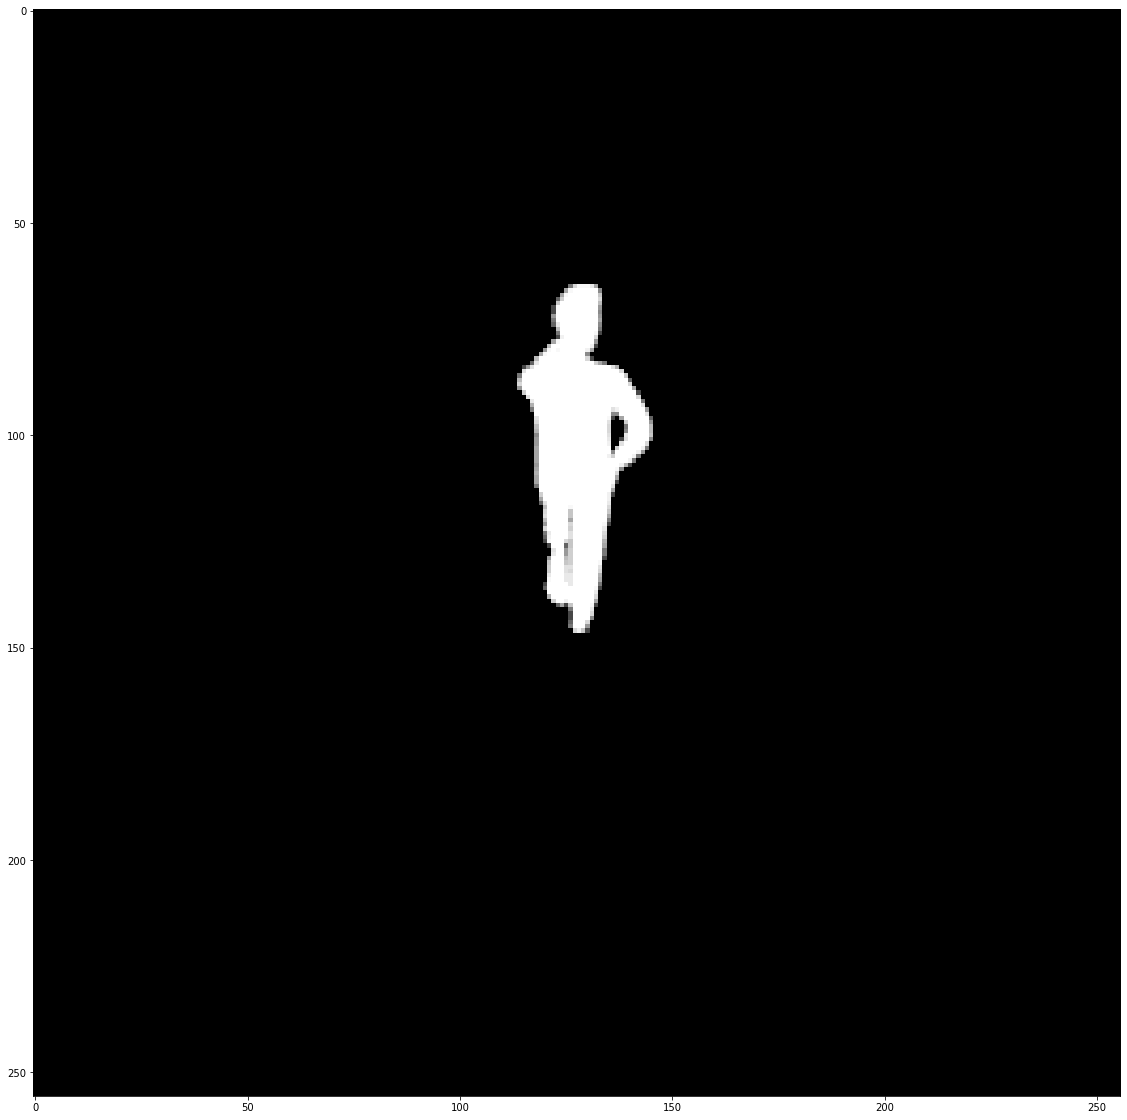

try save  light.png


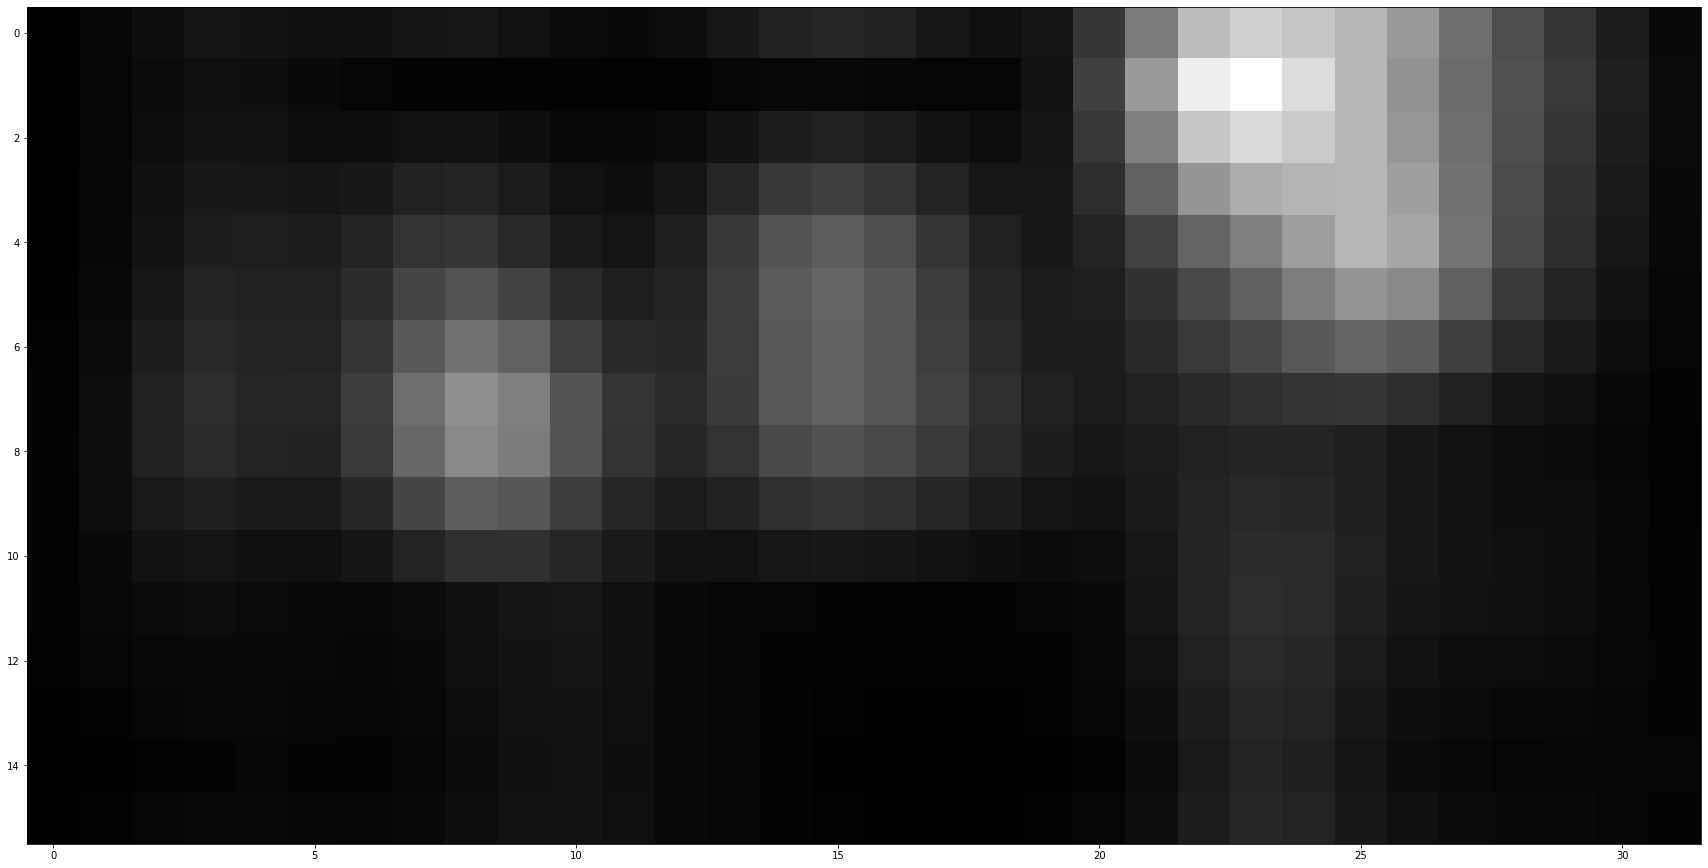

shadow min: 0.0, max: 30.826004028320312
cur batch range: 0.0, 1.0
cur batch illuminace sum: 99.87397766113281
show np size:  (256, 256, 3)
show min: 0.0, max: 1.0


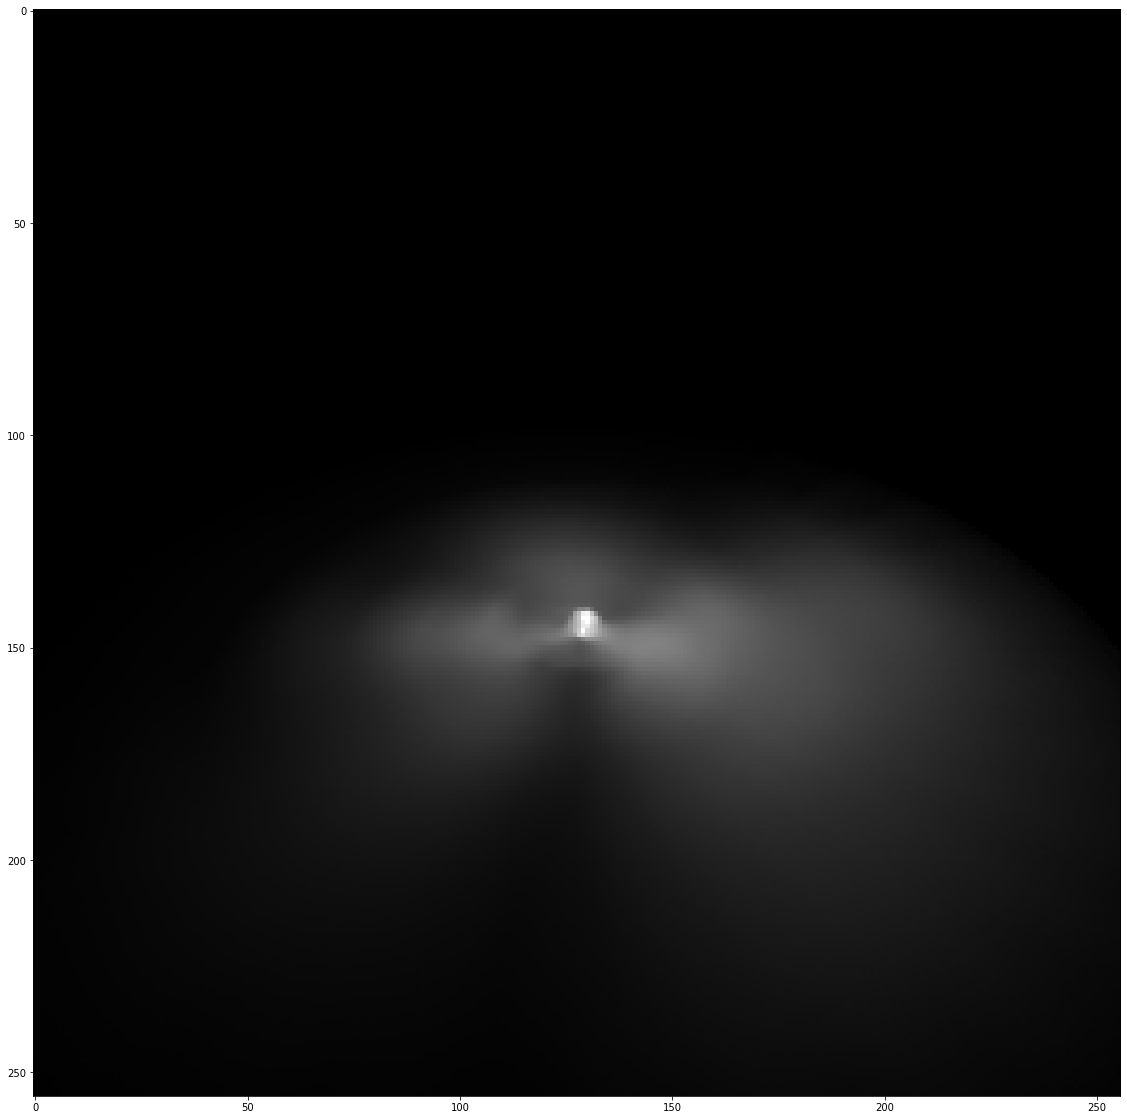

mask min: 0.0, max: 1.0
light min: 0.0020408183336257935, max: 0.8756282925605774
shadow min: 0.0, max: 18.074996948242188
try save  img_src.png


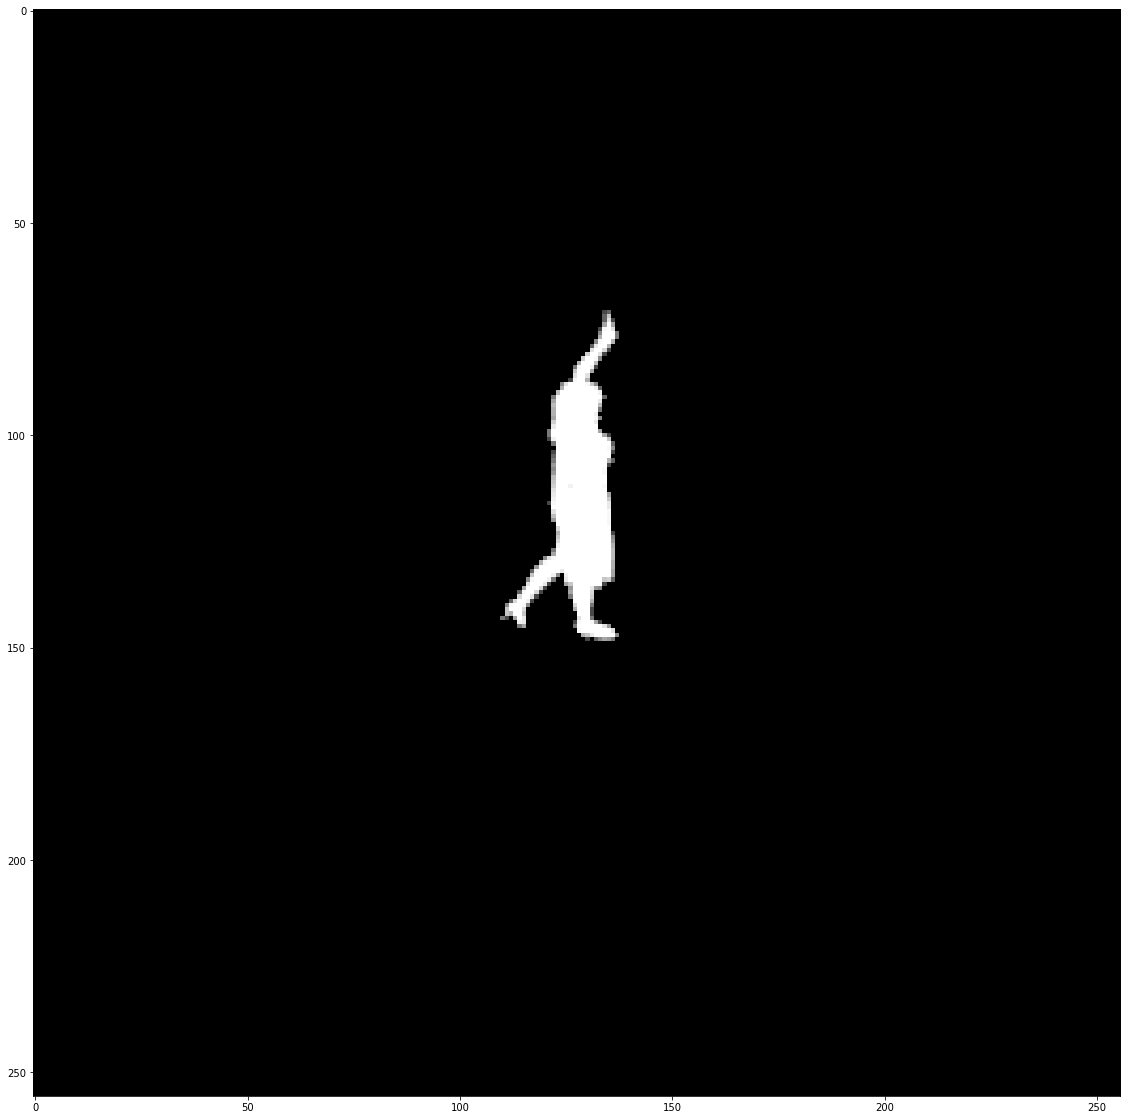

try save  light.png


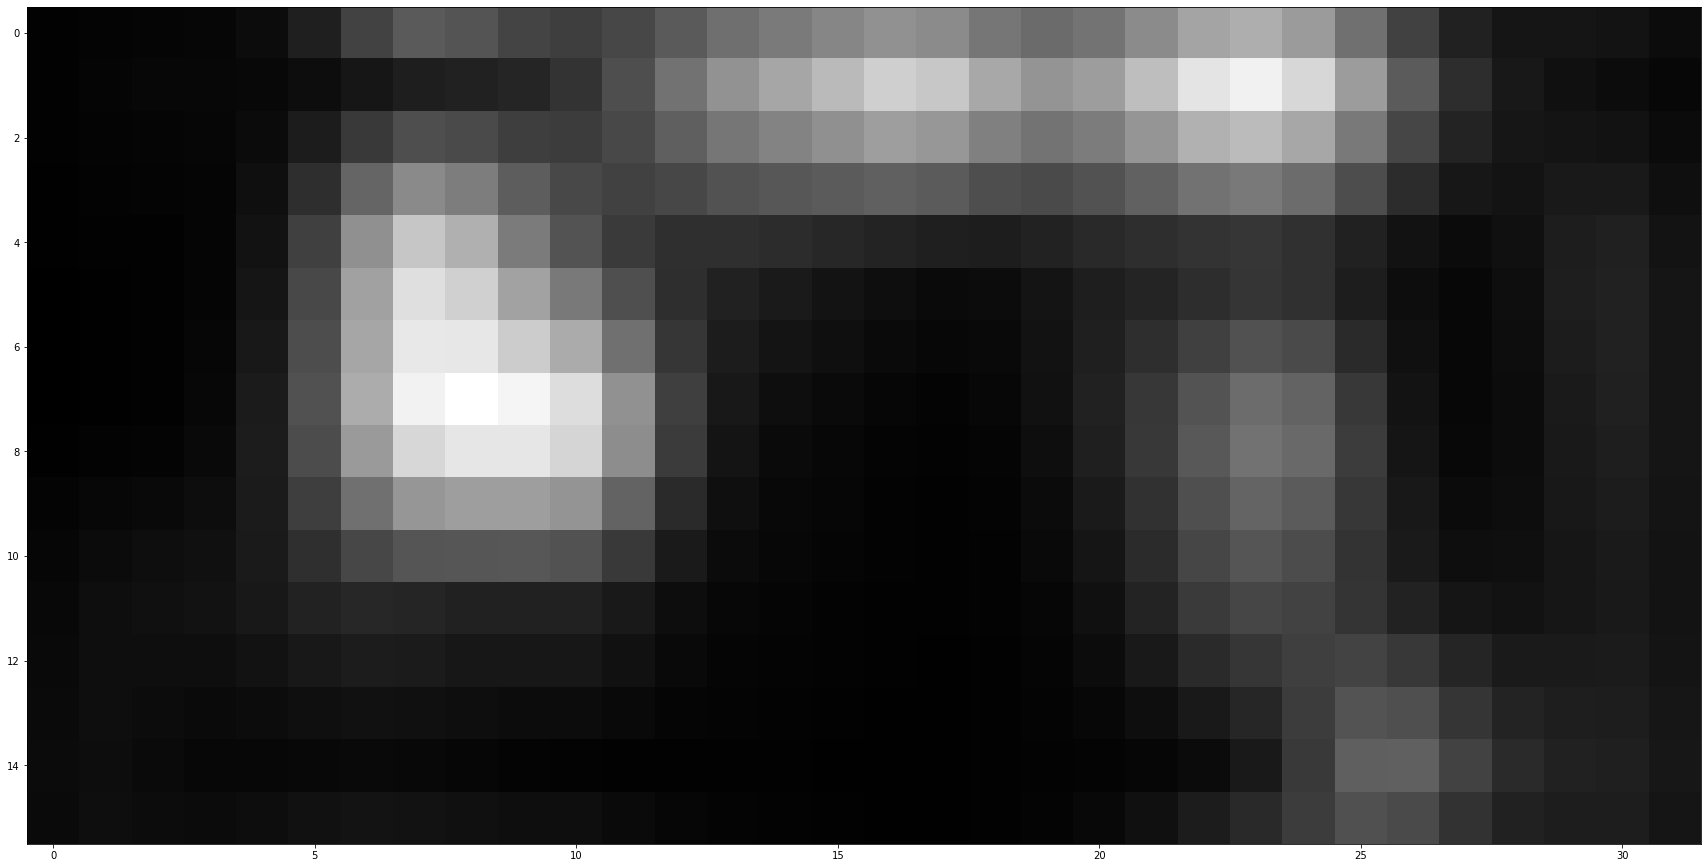

shadow min: 0.0, max: 18.074996948242188
cur batch range: 0.0, 0.8473475575447083
cur batch illuminace sum: 88.10958099365234
show np size:  (256, 256, 3)
show min: 0.0, max: 0.8473475575447083


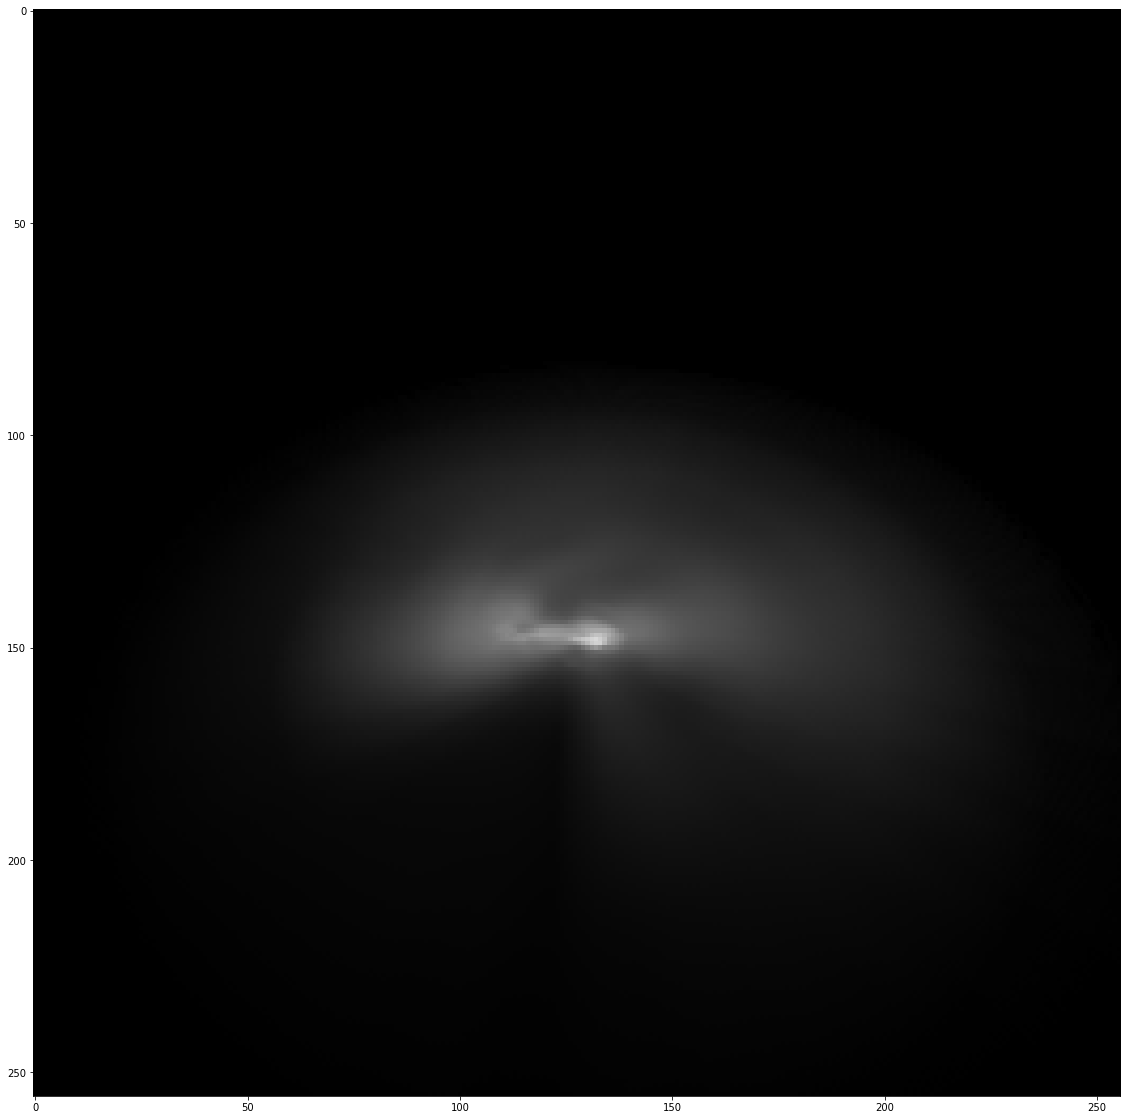

mask min: 0.0, max: 1.0
light min: 1.5014517884992529e-05, max: 1.5573484897613525
shadow min: 0.0, max: 39.887977600097656
try save  img_src.png


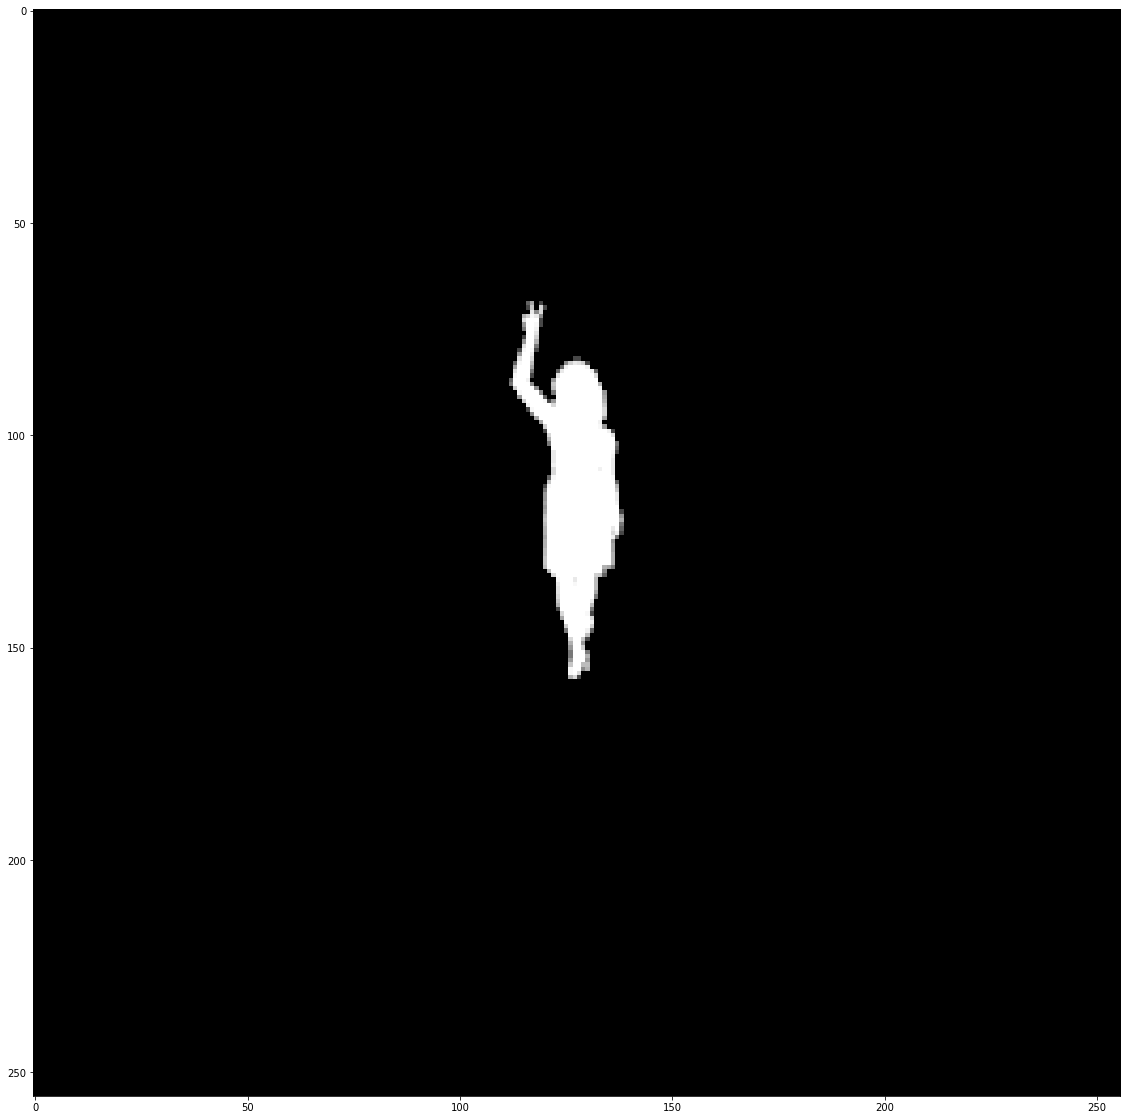

try save  light.png


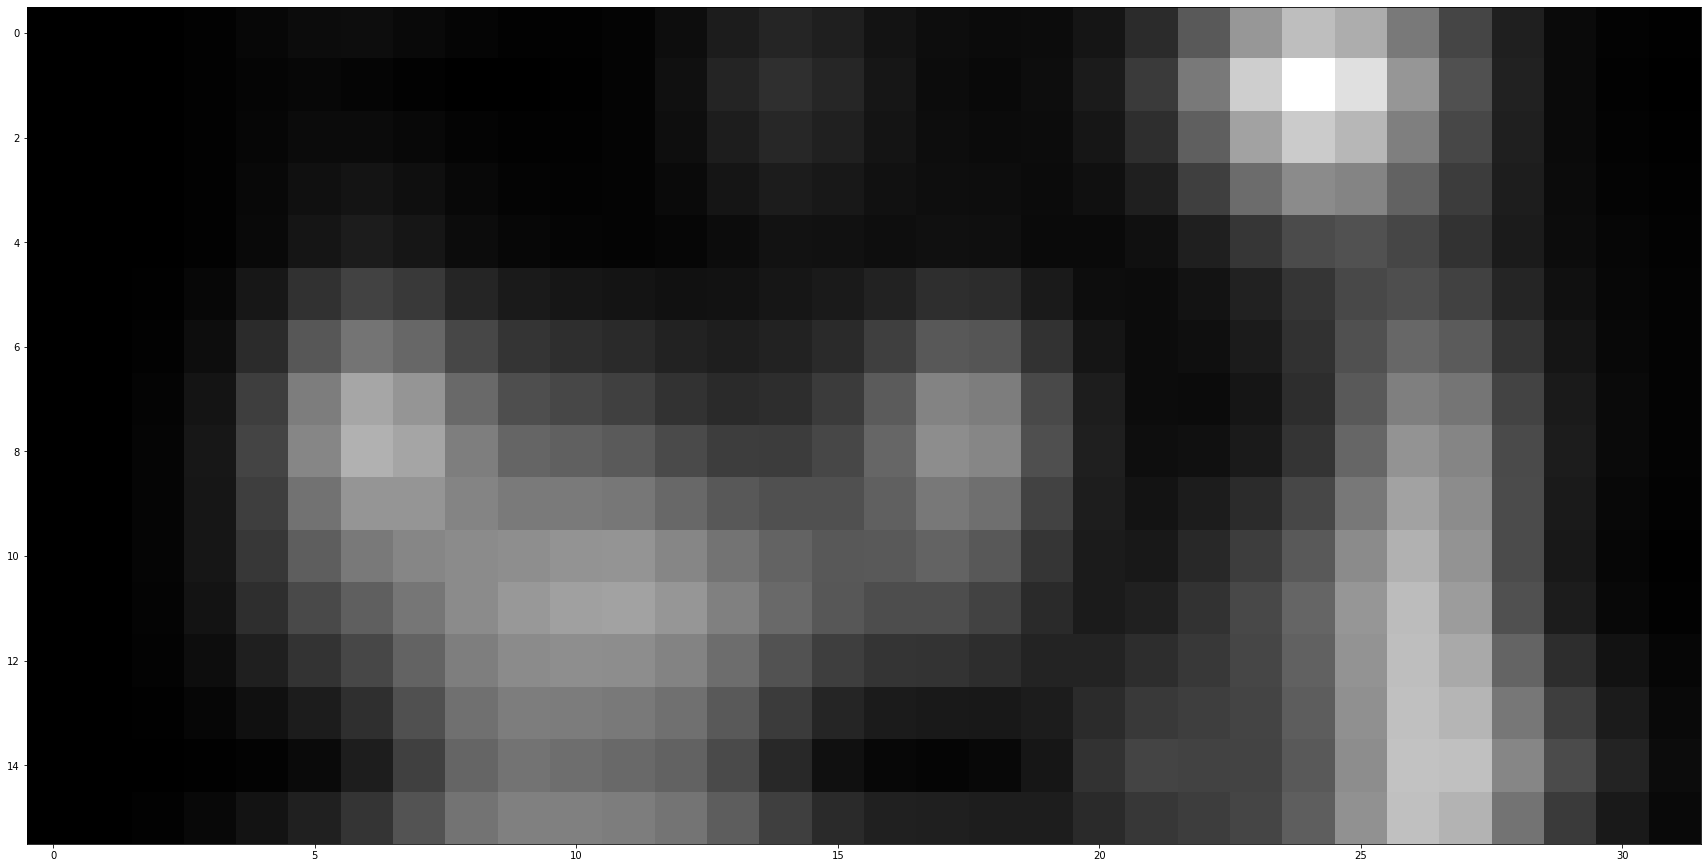

shadow min: 0.0, max: 39.887977600097656
cur batch range: 0.0, 0.8954427242279053
cur batch illuminace sum: 174.11428833007812
show np size:  (256, 256, 3)
show min: 0.0, max: 0.8954427242279053


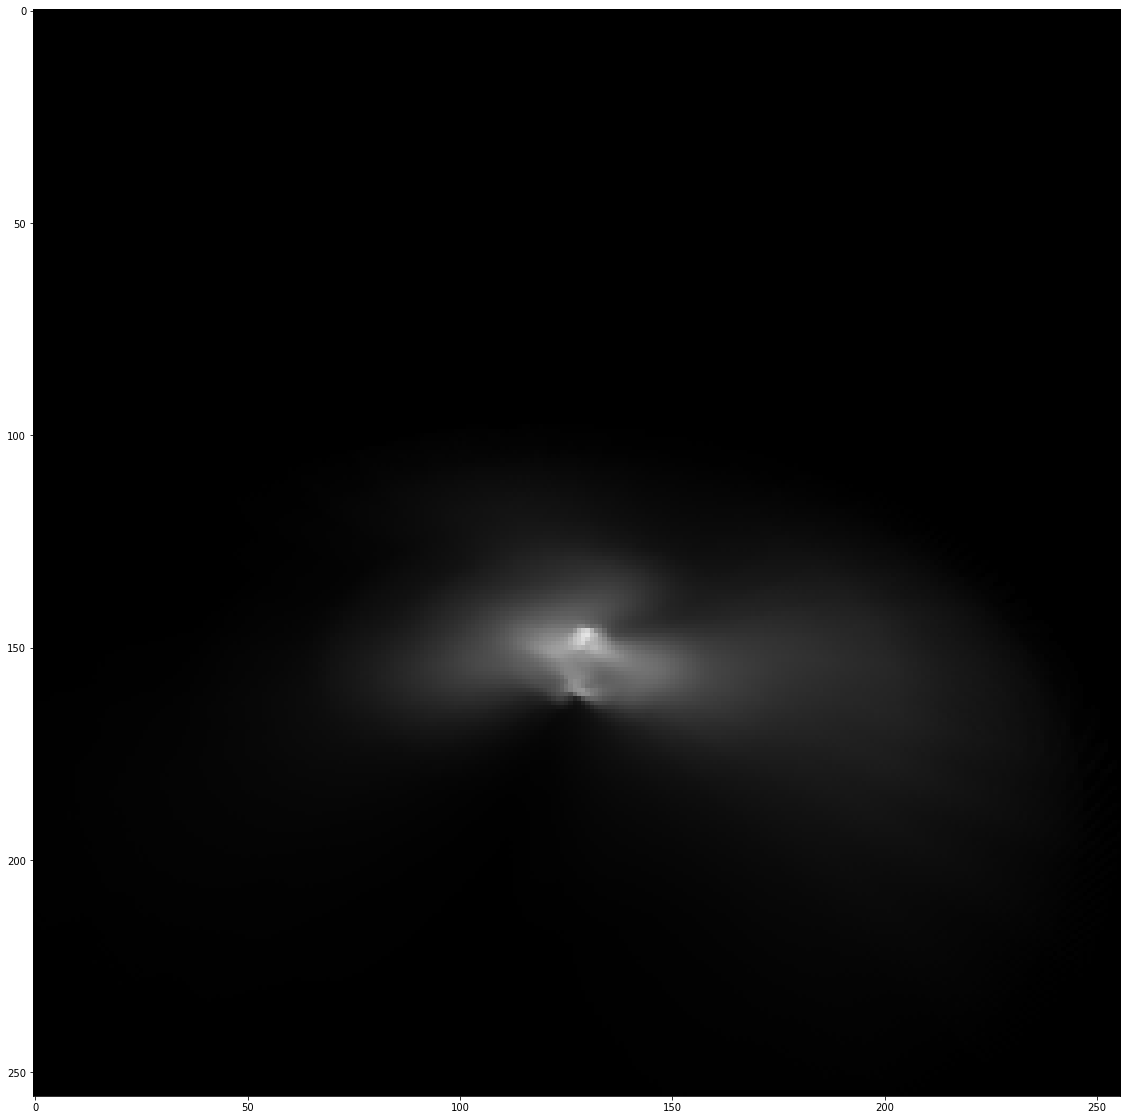

In [41]:
from torchvision import transforms, utils

def vis_light(light_tensor, new_ibl):
    if not new_ibl:
        batch, c, h, w = light_tensor.shape
        tensor_ret = torch.zeros((batch * c, 1, h, w))
        counter = 0

        for i in range(batch):
            for j in range(c):
                tensor_ret[counter,:,:,:] = light_tensor[i,j,:,:]
                counter += 1

        return tensor_ret
    else:
        b,c,d = light_tensor.shape
        ret = torch.zeros((b,16,32))
        for bi in range(b):
            cur_tensor = light_tensor[bi]
            print('alpha: ',torch.min(cur_tensor[:,0]), torch.max(cur_tensor[:,0]))
            print('beta: ',torch.min(cur_tensor[:,1]), torch.max(cur_tensor[:,1]))
            print('intensity: ',torch.min(cur_tensor[:,2]), torch.max(cur_tensor[:,2]))
            
            for i in range(c):
                alpha, beta, intensity = cur_tensor[i]
                # alpha: [-pi, pi]
                # beta: [-pi/2, pi/2]
                x = (alpha + np.pi)/np.pi * 0.5
                y = (beta + 0.5 * np.pi)/np.pi
                ret[bi, int(y * 16), int(x * 32)] = intensity
        
        return ret
                

def print_min_max(batch, comment):
    print('{} min: {}, max: {}'.format(comment, torch.min(batch), torch.max(batch)))

def show_img_batch(batch_img):
    grid = utils.make_grid(batch_img)
    show_np = grid.detach().cpu().numpy().transpose((1,2,0))
    print('show np size: ', show_np.shape)
    print('show min: {}, max: {}'.format(np.min(show_np), np.max(show_np)))
    plt.figure(figsize=(30,20))
    plt.imshow(show_np)
    plt.show()
    
for i, (mask, light, shadow) in enumerate(dataloader):
    if i >=  3:
        break
        
    # concatenate human mask and shadow mask
    I_s, L_t, I_t = mask, light, shadow
    print_min_max(I_s, 'mask')
    print_min_max(L_t, 'light')
    print_min_max(I_t, 'shadow')
    # print(L_t.shape)
    # L_t = vis_light(L_t, True)
    # print('after vis',L_t.shape)
    show_batch(I_s, 'img_src.png')
    show_batch(L_t/torch.max(L_t), 'light.png')
    
#     I_t = I_t/torch.max(I_t)
    print('shadow min: {}, max: {}'.format(torch.min(I_t), torch.max(I_t)))
    b,c,h,w = I_t.shape
    # I_t = torch.clamp(I_t/30.0, 0.0, 1.0)
    for batch in range(b):
        # I_t[batch, :, :, :] = I_t[batch, :, :, :]/torch.max(L_t[batch])
        # I_t[batch, :, :, :] = I_t[batch, :, :, :]/(0.5 * torch.max(I_t[batch, :, :, :])
        I_t[batch, :, :, :] = I_t[batch, :, :, :]/torch.sum(L_t[batch, :, :, :]) * 3.5
        I_t[batch, :, :, :] = torch.sqrt(I_t[batch, :, :, :])
        
        I_t[batch, :, :, :] = torch.clamp(I_t[batch, :, :, :], 0.0, 1.0)
        print('cur batch range: {}, {}'.format(torch.min(I_t[batch, :, :, :]), torch.max(I_t[batch, :, :, :])))
        print('cur batch illuminace sum: {}'.format(torch.sum(L_t[batch, :, :, :])))
    show_img_batch(I_t)
    
#     human_gt = I_t[:,0,:,:]
#     shadow_gt = I_t[:,1,:,:]
    
#     batch_size, c, h, w = I_t.size()
#     human_mask, shadow_mask = torch.zeros(batch_size, h, w, dtype= torch.float32), torch.zeros(batch_size, h, w, dtype= torch.float32)
#     human_mask[torch.where(human_gt !=0)] = 1
#     shadow_mask[torch.where(shadow_gt !=0)] = 1
    
# #     print(human_mask.size())
# #     print(shadow_mask.size())
   
#     show_batch(human_mask.view(batch_size, 1, h, w))
#     show_batch(shadow_mask.view(batch_size, 1, h, w))

In [ ]:
import seaborn 
import torch
import numpy as np
from scipy.ndimage.filters import gaussian_filter

def to_numpy_img(t):
    t_np = t.numpy()
    t_np = np.transpose(t_np, (1,2,0))
    return t_np

test_tensor = torch.zeros(9,256, 256)
test = to_numpy_img(test_tensor)
test[128, 128, 0] = 1

test_ = gaussian_filter(test, sigma = 10)
seaborn.heatmap(test[:,:,0])
seaborn.heatmap(test_[:,:, 0])

In [ ]:
import torch
import matplotlib.pyplot as plt
import math

# todo, vectorize this process
test_torch = torch.zeros(16,32)
for h in range(test_torch.size()[0]):
    test_torch[h,:] = abs(math.sin(h / 16.0 * 3.1415926)) + 0.001

test_np = test_torch.detach().cpu().numpy()

plt.figure()
plt.imshow(test_np,cmap='gray')light_np

In [ ]:
from ssn_submodule import Up
import torch

x1 = torch.randn(1,512, 16,16)
x2 = torch.randn(1,256, 32,32)

model = Up(512,256)
out = model(x1,x2)
print(out.size())

In [ ]:
data_file = '/home/ysheng/Dataset/soft_shadow/single_human/notsimulated_combine_male_short_outfits_genesis8_armani_casualoutfit03_Base_Pose_Standing_A/ground_truth.txt'

with open(data_file,'r') as f:
    content = f.readlines()

lines = [c.strip() for c in content]
data_num = int(len(lines)/6)

def get_pos(pos_str):
    x = float(pos_str[1])
    y = float(pos_str[2])
    z = float(pos_str[3])
    return np.array([x,y,z])

def get_spherical(pos):
    x,y,z = pos
    alpha = np.arctan2(z,x)
    beta = np.arctan2(y, np.sqrt(x**2 + z**2))
    return alpha, beta

prefix_list, alpha_list, beta_list = [], [], []
for i in range(data_num):
    prefix_str = lines[6 * i + 0]
    human_pos_str = lines[6 * i + 3].split()
    light_pos_str = lines[6 * i + 4].split()
    human_pos = get_pos(human_pos_str)
    light_pos = get_pos(light_pos_str)
    
    light_dir = light_pos - human_pos
    light_dir_norm = light_dir/np.linalg.norm(light_dir, 2)
    alpha, beta = get_spherical(light_dir_norm)
    # print('alpha: {}, beta: {} \n'.format(alpha, beta))
    alpha_list.append(alpha + np.pi)
    beta_list.append(beta + np.pi)    
    prefix_list.append(prefix_str)
    
alpha_ary = np.array(alpha_list)
beta_ary = np.array(beta_list)

In [ ]:
from PIL import Image

def compute_IBL(alpha, beta):
    h, w = 256, 256
    IBL = np.zeros((h,w))
    
    two_pi = 2.0 * np.pi
    alpha_coord, beta_coord = int(w * alpha/two_pi), int(h * beta/two_pi)
    IBL[beta_coord, alpha_coord] = 1.0
    return IBL

def show_gau_light(ibl):
    light_np = gaussian_filter(ibl, sigma=3)/np.max(ibl)
    plt.figure(figsize=(10,6))
    plt.imshow(light_np)

for i in range(6400):
    ibl = compute_IBL(alpha_ary[i], beta_ary[i])
    show_gau_light(ibl)

    light_img = '{}/{}_light.png'.format('/home/ysheng/Dataset/soft_shadow/single_human/notsimulated_combine_male_short_outfits_genesis8_armani_casualoutfit03_Base_Pose_Standing_A',prefix_list[i])
    # light_img_np = np.array(Image.open(light_img).resize((32,32)))
    light_img_np = np.array(Image.open(light_img))
    show_gau_light(light_img_np)
    
    if i > 10:
        break